# Note
Questo notebook è una modifica di quello proposto su kaggle [Notebook Kaggle](https://www.kaggle.com/code/abd0kamel/mutemotion-wlasl-translation-model/notebook), sono state eliminate le sezioni di codice che non risultavano utili per la dimostrazione di come le prestazioni del modello sarebbero dovute essere in un problema di regressione.

Le modifiche effettuate sono le seguenti:
- metrica di valutazione del modello da `accuracy` a `mse` (Mean Squared Error).


# **Introduction**

<h3> This notebook aims to use MediaPipe landmarks detection as the starting point
    
<h3> for building an American Sign Language Translation Model
            
**<h3> Sections:**
* [Importing Libraries](#Importing_Libraries)
* [Data Preparation](#Data_Preparation)
* [MediaPipe Implementation](#MediaPipe_Implementation)
* [Visualizing Landmarks](#Visualizing_Landmarks)
* [Data Encoding](#Data_Encoding)
* [Label Filtering](#Label_Filtering)
* [Data Loading](#Data_Loading)
* [Data Augmentation](#Data_Augmentation)
* [Data Preprocessing](#Data_Preprocessing)
* [Label Encoding](#Label_Encoding)
* [Models](#Models)
    
<h4> If you found this notebook helpful, an upvote would be appreciated!

---

<div id="Importing_Libraries">
    
# **Importing Libraries** 

In [1]:
!pip install -q mediapipe==0.10.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 4.7 MB/s eta 0:00:00


In [2]:
import os
import math
import gc
import json
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

---

<div id="Data_Loading">
    
# **Data Loading**

In [3]:
landmarks_dict = np.load('/kaggle/input/mutemotion-output/landmarks_V3.npz', allow_pickle=True)

In [4]:
labels_dict = np.load('/kaggle/input/mutemotion-output/labels.npz', allow_pickle=True)

In [5]:
with open('/kaggle/input/mutemotion-output/WLASL_parsed_data.json', 'r') as json_file:
    data = json.load(json_file)

<h3> Filter Landmarks (Only for V3)

In [6]:
filtered_hand = list(range(21))

filtered_pose = [11, 12, 13, 14, 15, 16]

filtered_face = [0, 4, 7, 8, 10, 13, 14, 17, 21, 33, 37, 39, 40, 46, 52, 53, 54, 55, 58,
                 61, 63, 65, 66, 67, 70, 78, 80, 81, 82, 84, 87, 88, 91, 93, 95, 103, 105,
                 107, 109, 127, 132, 133, 136, 144, 145, 146, 148, 149, 150, 152, 153, 154,
                 155, 157, 158, 159, 160, 161, 162, 163, 172, 173, 176, 178, 181, 185, 191,
                 234, 246, 249, 251, 263, 267, 269, 270, 276, 282, 283, 284, 285, 288, 291,
                 293, 295, 296, 297, 300, 308, 310, 311, 312, 314, 317, 318, 321, 323, 324,
                 332, 334, 336, 338, 356, 361, 362, 365, 373, 374, 375, 377, 378, 379, 380,
                 381, 382, 384, 385, 386, 387, 388, 389, 390, 397, 398, 400, 402, 405, 409,
                 415, 454, 466, 468, 473]

HAND_NUM = len(filtered_hand)
POSE_NUM = len(filtered_pose)
FACE_NUM = len(filtered_face)

In [7]:
landmarks = (
    [x for x in filtered_hand] +
    [x + HAND_NUM for x in filtered_hand] +
    [x + HAND_NUM * 2 for x in filtered_pose] +
    [x + HAND_NUM * 2 + POSE_NUM for x in filtered_face]
)

print(landmarks)
print(f'\nTotal Number: {len(landmarks)}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 53, 54, 55, 56, 57, 58, 48, 52, 55, 56, 58, 61, 62, 65, 69, 81, 85, 87, 88, 94, 100, 101, 102, 103, 106, 109, 111, 113, 114, 115, 118, 126, 128, 129, 130, 132, 135, 136, 139, 141, 143, 151, 153, 155, 157, 175, 180, 181, 184, 192, 193, 194, 196, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 220, 221, 224, 226, 229, 233, 239, 282, 294, 297, 299, 311, 315, 317, 318, 324, 330, 331, 332, 333, 336, 339, 341, 343, 344, 345, 348, 356, 358, 359, 360, 362, 365, 366, 369, 371, 372, 380, 382, 384, 386, 404, 409, 410, 413, 421, 422, 423, 425, 426, 427, 428, 429, 430, 432, 433, 434, 435, 436, 437, 438, 445, 446, 448, 450, 453, 457, 463, 502, 514, 516, 521]

Total Number: 180


<h3> Filter Data Source

In [8]:
# Only from the wlasl-processed dataset
# keys = [k for k in landmarks_dict.keys() if 'wlasl-processed' in data[int(k)]['video_path']]

# Only from the wlasl2000-resized dataset
# keys = [k for k in landmarks_dict.keys() if 'wlasl2000-resized' in data[int(k)]['video_path']]

<h3> Filter Labels

In [9]:
labels = []
with open('/kaggle/input/mutemotion-output/filtered_labels.txt', 'r') as file:
    labels = file.read().splitlines()

In [10]:
len(labels)

351

<h3> Loading Function

In [11]:
def load_data(split, labels=None, max_labels=None, max_samples=None, landmarks=None, keys=None):

    if landmarks is None:
        landmarks = list(range(landmarks_dict['0'].shape[1]))

    if keys is None:
        keys = [k for k in landmarks_dict.keys()]

    if labels is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split and data[int(k)]['gloss'] in labels]

    elif max_samples is not None:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split][:max_samples]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split][:max_samples]

    elif max_labels is not None:
        label_counts = {}
        for k in keys:
            label = data[int(k)]['gloss']
            label_counts[label] = label_counts.get(label, 0) + 1

        top_labels = sorted(label_counts, key=label_counts.get, reverse=True)[:max_labels]
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['gloss'] in top_labels and data[int(k)]['split'] == split]

    else:
        X = [landmarks_dict[k][:, landmarks, :] for k in keys
             if data[int(k)]['split'] == split]
        Y = [data[int(k)]['gloss'] for k in keys
             if data[int(k)]['split'] == split]

    return X, Y

In [12]:
X_train, Y_train = load_data('train', landmarks=landmarks, labels=labels)
X_val, Y_val = load_data('val', landmarks=landmarks, labels=labels)
X_test, Y_test = load_data('test', landmarks=landmarks, labels=labels)

In [13]:
len(X_train), len(X_val), len(X_test)

(2770, 748, 560)

In [14]:
X_train[0].shape

(81, 180, 3)

In [15]:
len(np.unique(Y_train)), len(np.unique(Y_val)), len(np.unique(Y_test))

(351, 351, 351)

In [16]:
np.all(np.in1d(np.unique(Y_val), np.unique(Y_train))),\
np.all(np.in1d(np.unique(Y_test), np.unique(Y_train)))

(True, True)

In [17]:
# free space
del landmarks_dict, data
gc.collect()

495

---

<div id="Data_Augmentation">
    
# **Data Augmentation**

<h3> Rotation Augmentations

In [18]:
def rotate(data, rotation_matrix):
    frames, landmarks, _ = data.shape
    center = np.array([0.5, 0.5, 0])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data = data.reshape(-1, 3)
    data[non_zero] -= center
    data[non_zero] = np.dot(data[non_zero], rotation_matrix.T)
    data[non_zero] += center
    data = data.reshape(frames, landmarks, 3)
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def rotate_z(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return rotate(data, rotation_matrix)

def rotate_y(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

def rotate_x(data):
    angle = np.random.choice([np.random.uniform(-30, -10),
                              np.random.uniform(10, 30)])
    theta = np.radians(angle)
    rotation_matrix = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return rotate(data, rotation_matrix)

<h3> Other Augmentations

In [19]:
def zoom(data):
    factor = np.random.uniform(0.8, 1.2)
    center = np.array([0.5, 0.5])
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], :2] = (
        (data[non_zero[:, 0], non_zero[:, 1], :2] - center) * factor + center
    )
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def shift(data):
    x_shift = np.random.uniform(-0.2, 0.2)
    y_shift = np.random.uniform(-0.2, 0.2)
    non_zero = np.argwhere(np.any(data[:, :, :2] != 0, axis=2))
    data[non_zero[:, 0], non_zero[:, 1], 0] += x_shift
    data[non_zero[:, 0], non_zero[:, 1], 1] += y_shift
    out_of_range = np.any((data[:, :, :2] < 0) | (data[:, :, :2] > 1), axis=2)
    data[out_of_range] = 0
    return data

def mask(data):
    frames, landmarks, _ = data.shape
    num_hands = int(0.3 * 42)
    num_rest = int(0.6 * (landmarks - 42))

    mask = np.zeros(landmarks, dtype=bool)
    indices = np.concatenate([
        np.random.choice(42, num_hands, replace=False),
        np.random.choice(landmarks - 42, num_rest, replace=False) + 42
    ])
    mask[indices] = True
    data[:, mask] = 0
    return data

def hflip(data):
    data[:, :, 0] = 1 - data[:, :, 0]
    return data

def speedup(data):
    return data[::2]

<h3> Apply Augmentations

In [20]:
def apply_augmentations(data):
    aug_functions = [rotate_x, rotate_y, rotate_z, zoom, shift, mask, hflip, speedup]
    np.random.shuffle(aug_functions)
    counter = 0
    for fun in aug_functions:
        if np.random.rand() < 0.5:
            data = fun(data)
            counter += 1

    if counter == 0:
        data = apply_augmentations(data)

    return data

In [21]:
def augment(X, Y, num=None):
    X_aug = X.copy()
    Y_aug = Y.copy()

    if num == None:
        for i in tqdm(range(len(Y)), ncols=100):
            num_aug = np.random.choice([1, 2, 3])
            for n in range(num_aug):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])
    elif num > 0:
        for i in tqdm(range(len(Y)), ncols=100):
            for n in range(num):
                X_aug.append(apply_augmentations(X[i].copy()))
                Y_aug.append(Y[i])

    return X_aug, Y_aug

In [22]:
X_train, Y_train = augment(X_train, Y_train, num=1)

100%|██████████████████████████████████████████████████████████| 2770/2770 [00:25<00:00, 109.58it/s]


In [23]:
len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0])

(5540, 81, 180, 3)

In [24]:
# free space
gc.collect()

0

<h3> Data Permutation

In [25]:
permutation_train = list(range(len(Y_train)))
np.random.shuffle(permutation_train)
X_train = [X_train[i] for i in permutation_train]
Y_train = [Y_train[i] for i in permutation_train]

permutation_val = list(range(len(Y_val)))
np.random.shuffle(permutation_val)
X_val = [X_val[i] for i in permutation_val]
Y_val = [Y_val[i] for i in permutation_val]

permutation_test = list(range(len(Y_test)))
np.random.shuffle(permutation_test)
X_test = [X_test[i] for i in permutation_test]
Y_test = [Y_test[i] for i in permutation_test]

---

<div id="Data_Preprocessing">
    
# **Data Preprocessing**

<h3>
    
**Method 1:** Sequencing

In [26]:
def sequences(X, Y, length=30, step=1, pad=0):
    X_sequences = []
    Y_sequences = []

    for inputs, label in zip(X, Y, strict=False):
        num = inputs.shape[0]

        if num < length:
            padding = length - num
            inputs = np.pad(
            inputs, ((0, padding), (0, 0), (0, 0)),
            mode='constant', constant_values=pad
            )
            num = length

        for start in range(0, num - length + 1, step):
            end = start + length
            sequence = inputs[start:end]
            X_sequences.append(sequence)
            Y_sequences.append(label)

    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    return X_sequences, Y_sequences

In [27]:
X_train, Y_train = sequences(X_train, Y_train, length=60, step=20, pad=-100)
X_val, Y_val = sequences(X_val, Y_val, length=60, step=20, pad=-100)
X_test, Y_test = sequences(X_test, Y_test, length=60, step=20, pad=-100)

In [28]:
X_train.shape, X_val.shape, X_test.shape

((7045, 60, 180, 3), (1008, 60, 180, 3), (697, 60, 180, 3))

<h3>
    
**Method 2:** Padding

In [29]:
def padding(X, Y, length=None, pad=0):
    if length is None:
        length = max(len(x) for x in X)

    X_padded = []
    for x in X:
        if len(x) > length:
            X_padded.append(x[:length]) #truncate
        else:
            pad_length = length - len(x)
            X_padded.append(np.pad(
                x, ((0, pad_length), (0, 0), (0, 0)),
                mode='constant', constant_values=pad
            ))

    X_padded = np.array(X_padded)
#     Y = np.array(Y)
    return X_padded, Y

In [30]:
X_train, Y_train = padding(X_train, Y_train, length=200, pad=-100)
X_val, Y_val = padding(X_val, Y_val, length=200, pad=-100)
X_test, Y_test = padding(X_test, Y_test, length=200, pad=-100)

In [31]:
X_train.shape, X_val.shape, X_test.shape

((7045, 200, 180, 3), (1008, 200, 180, 3), (697, 200, 180, 3))

<h3>
    
**Method 3:** Skipping & Cloning

In [32]:
def skipping(landmarks, desired_frames,mode='floor'):
    frames_num = landmarks.shape[0]
    if mode == 'floor':
        skip_factor = math.floor(frames_num / desired_frames)
    elif mode == 'ceil':
        skip_factor = math.ceil(frames_num / desired_frames)
    skipped_landmarks = []

    for i in range(0, frames_num, skip_factor):
        skipped_landmarks.append(landmarks[i])
        if len(skipped_landmarks)==desired_frames:
            break

    return np.array(skipped_landmarks)

# Test
skip_test = np.zeros((90, 180, 3))
result_1 = skipping(skip_test, 60)
result_2 = skipping(skip_test, 60,'ceil')
print(result_1.shape)
print(result_2.shape)

(60, 180, 3)
(45, 180, 3)


In [33]:
def cloning(landmarks, desired_frames):

    frames_num = landmarks.shape[0]
    repeat_factor = math.ceil(desired_frames / frames_num)

    cloned_list = np.repeat(landmarks, repeat_factor, axis=0)
    cloned_list = cloned_list[:desired_frames]
    return cloned_list

# Test
clone_test = np.random.random((29, 180, 3))
result = cloning(clone_test, 60)
print(result.shape)

(60, 180, 3)


In [34]:
def clone_skip(landmarks_array,desired_frames):
    reshaped_landmarks = []
    for landmarks in landmarks_array:
        frames_number = landmarks.shape[0]

        if frames_number == desired_frames:
            reshaped_landmarks.append(landmarks)
        elif frames_number < desired_frames:
            reshaped_landmarks.append(cloning(landmarks,desired_frames))
        elif frames_number > desired_frames:
            reshaped_landmarks.append(skipping(landmarks,desired_frames))
    return np.array(reshaped_landmarks)

---

<div id="Label_Encoding">
    
# **Label Encoding**

In [35]:
# label_encoder = LabelEncoder()

# Y_train = label_encoder.fit_transform(Y_train)
# Y_val = label_encoder.fit_transform(Y_val)
# Y_test = label_encoder.fit_transform(Y_test)

In [36]:
Y_train = np.array([labels_dict[label] for label in Y_train])
Y_val = np.array([labels_dict[label] for label in Y_val])
Y_test = np.array([labels_dict[label] for label in Y_test])

In [37]:
Y_train.shape

(7045, 300)

In [38]:
# free space
gc.collect()

726

---

<div id="Models">
    
# **Models**

<h2>Kamel's Model

In [39]:
gc.collect()
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=-100, input_shape=(200, 180, 3)),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(300, activation='linear')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'flatten' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [41]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True
)

model.compile(
    loss=tf.keras.losses.cosine_similarity,
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    metrics=['mse']
)

In [42]:
hist = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1000,
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - loss: -0.0757 - mse: 4.1586 - val_loss: 0.4518 - val_mse: 799.7646
Epoch 2/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: -0.3775 - mse: 19.1561 - val_loss: 0.3573 - val_mse: 141.7207
Epoch 3/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: -0.4094 - mse: 24.4907 - val_loss: 0.1364 - val_mse: 61.2611
Epoch 4/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: -0.4282 - mse: 28.7067 - val_loss: -0.4433 - val_mse: 83.9519
Epoch 5/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: -0.4281 - mse: 30.2672 - val_loss: -0.4121 - val_mse: 102.6554
Epoch 6/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: -0.4295 - mse: 27.4879 - val_loss: -0.4525 - val_mse: 78.7357
Epoch 7/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: -0.4390 - mse: 28.6582 - val_loss: -0.4553 - val_mse: 43.9263
Epoch 8/1000
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: -0.4426 - mse: 26.5605 - val_loss: -0.4585 - val_mse: 30.6389
Epoch 9/1000
56

In [43]:
# epoch = 90
# model.load_weights(f'/kaggle/working/Kamel_Checkpoints/model_{epoch}.h5')
test_loss, test_mse = model.evaluate(X_test, Y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: -0.4723 - mse: 75.1958


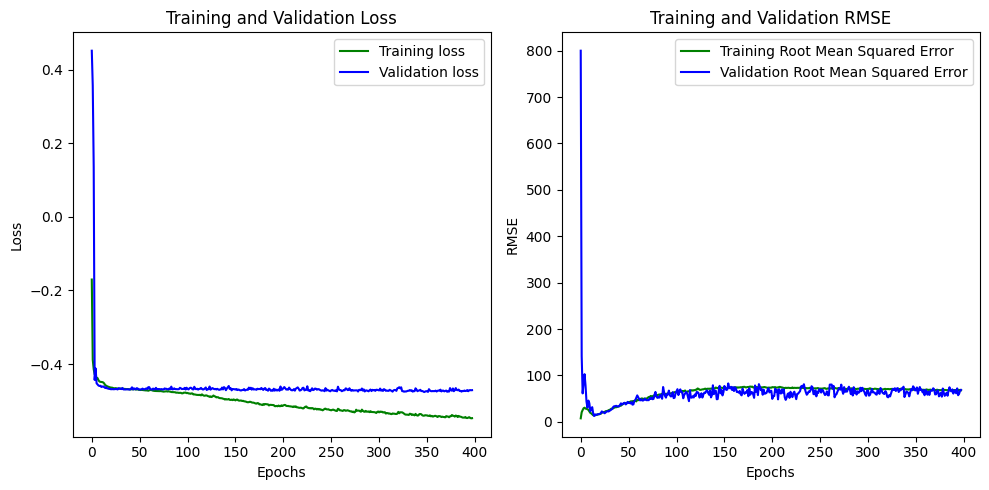

In [44]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_mse = hist.history['mse']
val_mse = hist.history['val_mse']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_mse, 'g', label='Training Mean Squared Error')
plt.plot(val_mse, 'b', label='Validation Mean Squared Error')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

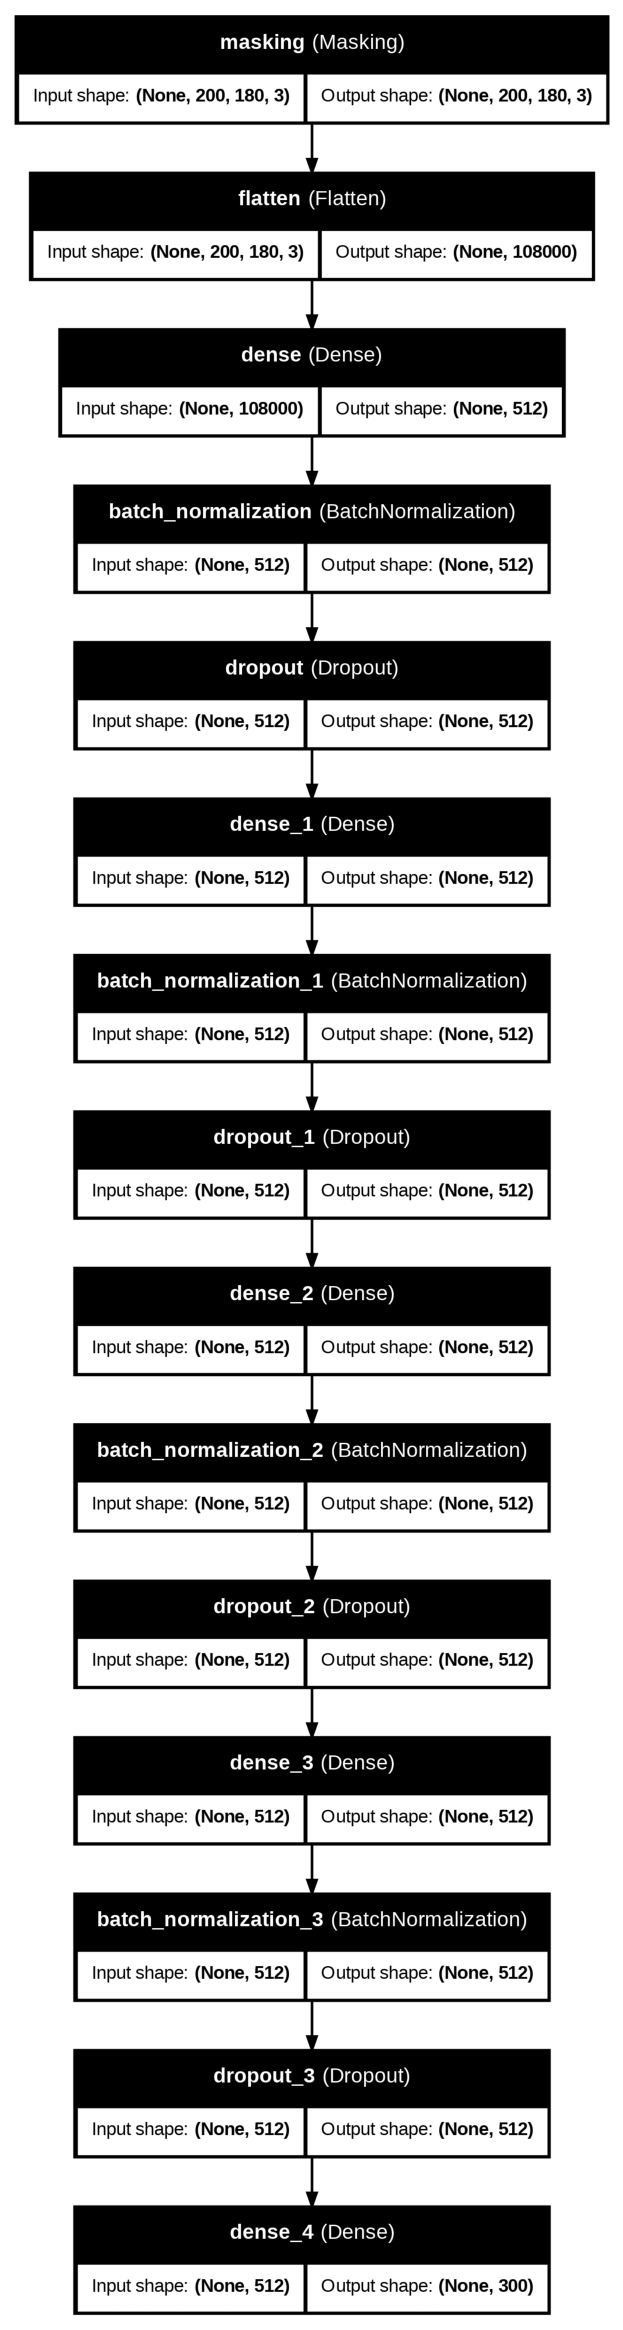

In [45]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
img = plt.imread('model_plot.png')
plt.figure(figsize=(40, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

In [46]:
name = '12-14'
model_filepath = '/kaggle/working/Kamel_Models'
os.makedirs(model_filepath, exist_ok=True)

model.save(model_filepath + f'/{name}.keras')
model.save(model_filepath + f'/{name}.h5')